# Deep Learning (Foundations): Course Project

**University:** NOVA Information Management School<br/>
**Program:** Master’s Degree Program in Data Science and Advanced Analytics<br/>
**Academic Year:** 2022/2023

```
============== Students: ==============
Iryna Savchuk (m20211310@novaims.unl.pt)
Cátia Sofia Pereira Parrinha (m20201320@novaims.unl.pt)
Giulia Bovenga (m20221637@novaims.unl.pt)
Hubert Oberhauser (m20220628@novaims.unl.pt)
Leo Allgaier (m20220635@novaims.unl.pt)
=======================================
```
**Data Source**
*   Clean data to perform model training can be downloaded from here: [datasets.zip](https://drive.google.com/file/d/1xMF-lupg9UX-UZUD6NlC2h-Ao08gQ6f3/view?usp=sharing)

* Original data can be downloaded from here: [train](https://storage.googleapis.com/ibeans/train.zip) - [validation](https://storage.googleapis.com/ibeans/validation.zip) - [test](https://storage.googleapis.com/ibeans/test.zip)

* Original data description: https://github.com/AI-Lab-Makerere/ibean/
------------------------------
**Summary**

The current notebook contains Optional Technique #1 - **Tranfer Learning**.
The main [outcomes](#scrollTo=hHSnWq7TeSS6) are summed up in the last section of the current notebook.

------------------------------

**References**
1. "Deep Learning with Python", 2nd Edition (2021), by François Chollet, Manning Publications - Chapter 8.3 Leveraging a pretrained model.
2. "Complete guide to transfer learning & fine-tuning in Keras" by François Chollet [official documentation](https://keras.io/guides/transfer_learning/).
3. ``tf.keras.utils.image_dataset_from_directory``, [official documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).
4. ``tf.keras.applications.vgg16.VGG16``, [official documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16).
5.[VGGNet (2015), by K. Simonyan & A. Zisserman](https://arxiv.org/pdf/1409.1556v6.pdf).
6. ImageNet, [official web-site](https://image-net.org/about.php).
7. ``tf.keras.applications.mobilenet_v2.MobileNetV2`` [official documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2)

## Importing Packages and Setting up the Machine

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, Model, layers, initializers, regularizers, optimizers, metrics 
import keras

from google.colab import drive
import os
import time
import shutil
import random 
import zipfile

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Set the machine:
gdrive = True

# Set the connection string
path = "/content/gdrive/MyDrive/DL_Project/"

In [ ]:
main_folder, training_folder, validation_folder, testing_folder = "datasets/", "train/", "validation/", "test/"

# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/gdrive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'datasets.zip', 'datasets.zip')
    # Extract files
    zip_ = zipfile.ZipFile('datasets.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = "/content/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File transfer completed in 1.398 seconds


As a preparation step for the current notebook, let's also define a supplementary function that we will use later, when training a model, to plot learning curves:

In [ ]:
# Suplementary function to Plot out Learning Curves
def plot_learning_curves(history):
  df_hist = pd.DataFrame.from_dict(history.history)
  df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

  secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
  ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                    secondary_y = secondary_y,
                    kind="line", figsize=(6, 3), grid=True, legend=True,
                    ylabel="Categorical cross-entropy", 
                    xlabel="Epoch", title="Learning curves",                  
                    color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
  ax.right_ax.set_ylabel("Categorical Accuracy")
  ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
  ax.legend(loc=(0, -0.45), framealpha=1.0)
  plt.show()

## Creating Train, Validation and Test Datasets

In [ ]:
image_size=(128, 128)  
crop_to_aspect_ratio=False 
color_mode='rgb'  
batch_size=64  
label_mode="categorical"  
shuffle=True  
seed=0  

In [ ]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_validation = image_dataset_from_directory(path + main_folder + validation_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']


## Transfer Learning overview. Choosing pre-trained models for our case. 

Transfer learning consists of taking features learned on one problem, and leveraging them on a new problem.

The most common workflow for applying Transfer Learning is the following:
1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

Keras comes with a number of already built image classification models, all pretrained on the ImageNet dataset and available as a part of ``keras.applications``. The full list of available models can be reviewed [here]( https://keras.io/api/applications/#usage-examples-for-image-classification-models).

For the problem of the beans classification at hand, we decided to use the following two existing models:

1. VGG16 
2. MobileNetV2

**Reasoning for our choice.**

1. The main reasoning for chosing **VGG16** is that, among all the available models, it has the lowest depth (where depth refers to the topological depth of the network and includes activation layers, batch normalization layers etc.) According to "Deep Learning with Python" referenced in this notebook, in convolutional architectures, layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eye”). We believe, the problem of bean plans classification does not need that high level abstraction.

2. The classification problem of bean plants images originates to the end goal to build a robust model that can be deployed on a mobile device and used in the field by a farmer. **MobileNet** architecture is special in this way because it uses very less computation power to run. Among all the available pretrained models, the size of MobileNet is the smallest one, which makes it a perfect fit for mobile devices, embedded systems, and computers to run without GPUs. Furthermore, MobileNetV2 is an improved iteration of MobileNetV1 that provides even greater efficiency and power. This is achieved through a reduction in model size and complexity, resulting in faster performance for MobileNetV2 models.






## 1.Using convolutional base of the VGG16

The VGG16 model, among others, comes prepackaged with Keras. It is possible to import it from the ``keras.applications`` module. Let’s instantiate the VGG16 model:

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

The final feature map has shape (4, 4, 512). That is the feature map on top of which we will stick a densely connected classifier to distinguish between 3 classes of bean plans.

There are two ways we could proceed to extract features:

* Run the convolutional base over our dataset, record its output to a NumPy array on disk, and then use this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow us to use data augmentation.

* Extend the model we have (conv_base) by adding Dense layers on top, and run the whole thing from end to end on the input data. This will allow us to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

### 1.1.Fast Feature Extraction without Data Augmentation

In [ ]:
# Extracting the VGG16 features and corresponding labels
def get_features_and_labels(dataset): 
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images) 
    features = conv_base.predict(preprocessed_images) 
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)


train_features, train_labels = get_features_and_labels(ds_train) 
val_features, val_labels = get_features_and_labels(ds_validation) 
test_features, test_labels = get_features_and_labels(ds_test)

2/2 [==============================] - 0s 31ms/step


In [ ]:
train_features.shape

(1034, 4, 4, 512)

Importantly, predict() only expects images, not labels, but our current dataset yields batches that contain both images and their labels. Moreover, the VGG16 model expects inputs that are preprocessed with the function keras.applications.vgg16.preprocess_input, which scales pixel values to an appropriate range.

In [ ]:
# Defining and training the densely connected classifier
inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units=3, activation="softmax")(x)
model = keras.Model(inputs, outputs)


model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",  
              metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
              metrics.AUC(name='AUROC')])


callbacks = [keras.callbacks.ModelCheckpoint(
             filepath="feature_extraction.keras",
             save_best_only=True,
             monitor="val_loss")
]

history = model.fit(train_features, train_labels,
                    epochs=20,
                    validation_data=(val_features, val_labels),
                    callbacks=callbacks)

Epoch 1/20
33/33 [==============================] - 1s 15ms/step - loss: 55.6381 - categorical_accuracy: 0.6364 - AUROC: 0.7328 - val_loss: 26.9393 - val_categorical_accuracy: 0.7068 - val_AUROC: 0.7779
Epoch 2/20
33/33 [==============================] - 0s 6ms/step - loss: 9.7583 - categorical_accuracy: 0.8607 - AUROC: 0.9067 - val_loss: 12.5908 - val_categorical_accuracy: 0.8346 - val_AUROC: 0.8816
Epoch 3/20
33/33 [==============================] - 0s 5ms/step - loss: 8.2869 - categorical_accuracy: 0.8849 - AUROC: 0.9190 - val_loss: 13.3263 - val_categorical_accuracy: 0.8195 - val_AUROC: 0.8659
Epoch 4/20
33/33 [==============================] - 0s 6ms/step - loss: 3.6543 - categorical_accuracy: 0.9323 - AUROC: 0.9541 - val_loss: 11.4217 - val_categorical_accuracy: 0.8722 - val_AUROC: 0.9083
Epoch 5/20
33/33 [==============================] - 0s 5ms/step - loss: 3.8640 - categorical_accuracy: 0.9352 - AUROC: 0.9542 - val_loss: 15.3939 - val_categorical_accuracy: 0.8496 - val_AUROC: 

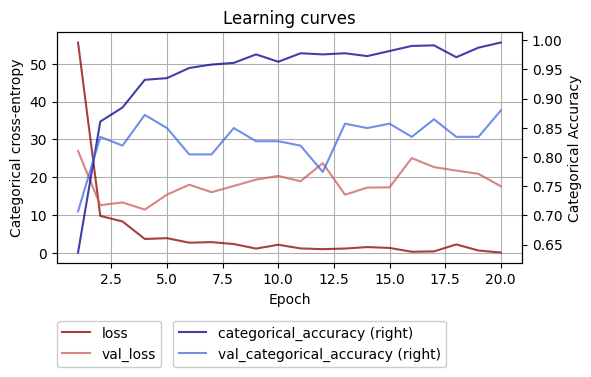

In [ ]:
# Ploting out the learning curves
plot_learning_curves(history)

The plots above indicate that the model is overfitting almost from the start — despite the fact that we are using dropout with a fairly large rate (0.5). The thing is that this technique does not use data augmentation, which is essential to prevent overfitting when dealing with small image datasets.

###1.2. Feature Extraction with Data Augmentation

Now let’s review the second technique for doing feature extraction, which is much slower and more expensive, but which allows us to use data augmentation during training: creating a model that chains the conv_base with a new dense classifier, and training it end to end on the inputs.

In order to do this, we will first freeze the convolutional base. In Keras, we freeze a layer or model by setting its ***trainable*** attribute to ***False***.

In [ ]:
# Instantiating and freezing the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
    )

conv_base.trainable = False

In [ ]:
# Printing the list of trainable weights before and after freezing
conv_base.trainable = True
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Now we can create a new model that chains together the following steps:
1. A data augmentation stage
2. The frozen convolutional base of pre-trained VGG16
3. A dense classifier

In [ ]:
# Defining Augmentation
data_augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.2), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomContrast(factor=0.3),
                           layers.RandomBrightness(factor=0.3),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))])

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x) # notice preprocess_unit here
x = conv_base(x) # notice 'conv_base' here
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model= keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",  
              metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
              metrics.AUC(name='AUROC')])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                           

Let’s train the model on our date. Since we do data augmentation this time, it will take longer time for the model to start overfitting, so we can train the model for more epochs—let’s do 50.

**IMPORTANT NOTE:** This technique is expensive enough that you should only attempt it if you have access to a GPU (such as the free GPU available in Colab)—it’s intractable on CPU.

In [ ]:
# turning off warnings for augmentation layer:
# https://stackoverflow.com/questions/73304934/tensorflow-data-augmentation-gives-a-warning-using-a-while-loop-for-converting
tf.get_logger().setLevel('ERROR')


callbacks = [keras.callbacks.ModelCheckpoint(
              filepath="feature_extraction_with_data_augmentation.keras",
              save_best_only=True,
              monitor="val_loss")]


history = model.fit(ds_train,
                    epochs=50,
                    validation_data=ds_validation,
                    callbacks=callbacks)

Epoch 1/50
17/17 [==============================] - 10s 153ms/step - loss: 66.6032 - categorical_accuracy: 0.5338 - AUROC: 0.6541 - val_loss: 30.3889 - val_categorical_accuracy: 0.6767 - val_AUROC: 0.7590
Epoch 2/50
17/17 [==============================] - 3s 132ms/step - loss: 23.5554 - categorical_accuracy: 0.6702 - AUROC: 0.7619 - val_loss: 41.6605 - val_categorical_accuracy: 0.6466 - val_AUROC: 0.7479
Epoch 3/50
17/17 [==============================] - 5s 178ms/step - loss: 28.9637 - categorical_accuracy: 0.6654 - AUROC: 0.7580 - val_loss: 32.0367 - val_categorical_accuracy: 0.6391 - val_AUROC: 0.7293
Epoch 4/50
17/17 [==============================] - 3s 142ms/step - loss: 18.2249 - categorical_accuracy: 0.7021 - AUROC: 0.7832 - val_loss: 13.5394 - val_categorical_accuracy: 0.7895 - val_AUROC: 0.8522
Epoch 5/50
17/17 [==============================] - 3s 128ms/step - loss: 14.6907 - categorical_accuracy: 0.7292 - AUROC: 0.8067 - val_loss: 36.8722 - val_categorical_accuracy: 0.6767

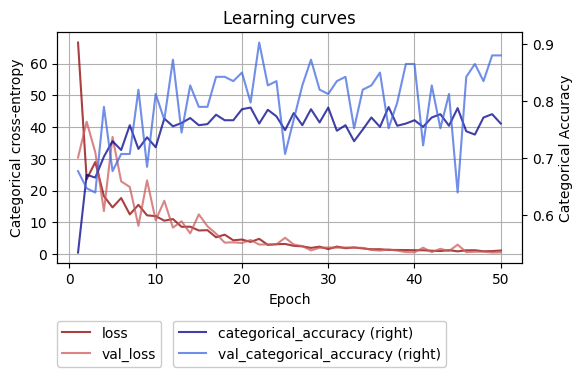

In [ ]:
# Ploting out the learning curves
plot_learning_curves(history)

###1.3.Fine-tuning a pretrained model

Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers.

The steps for fine-tuning a network are as follows:
1. Add the custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part we added.



We already completed the first three steps when doing feature extraction in the previous step (see 1.2). Let’s proceed with step 4 now: we will unfreeze our conv_base and then freeze individual layers inside it.

In [ ]:
# Printing out the 'conv_base' structure
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

We will fine-tune the last three convolutional layers, which means all layers up to block4_pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable.

In [ ]:
# Freezing all the layers until the fourth from the last
# and unfreezing the rest, latest layers
conv_base.trainable = True

for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
# Fine-tuning the model
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), 
              metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
              metrics.AUC(name='AUROC')])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_validation,
    callbacks=callbacks)

Epoch 1/30
17/17 [==============================] - 6s 179ms/step - loss: 0.6463 - categorical_accuracy: 0.8230 - AUROC: 0.9435 - val_loss: 0.4091 - val_categorical_accuracy: 0.8947 - val_AUROC: 0.9686
Epoch 2/30
17/17 [==============================] - 4s 203ms/step - loss: 0.5224 - categorical_accuracy: 0.8317 - AUROC: 0.9516 - val_loss: 0.4858 - val_categorical_accuracy: 0.8647 - val_AUROC: 0.9590
Epoch 3/30
17/17 [==============================] - 4s 162ms/step - loss: 0.4836 - categorical_accuracy: 0.8617 - AUROC: 0.9549 - val_loss: 0.3814 - val_categorical_accuracy: 0.8872 - val_AUROC: 0.9754
Epoch 4/30
17/17 [==============================] - 4s 160ms/step - loss: 0.4434 - categorical_accuracy: 0.8472 - AUROC: 0.9591 - val_loss: 0.3486 - val_categorical_accuracy: 0.8872 - val_AUROC: 0.9764
Epoch 5/30
17/17 [==============================] - 5s 246ms/step - loss: 0.4203 - categorical_accuracy: 0.8491 - AUROC: 0.9599 - val_loss: 0.3975 - val_categorical_accuracy: 0.8872 - val_AURO

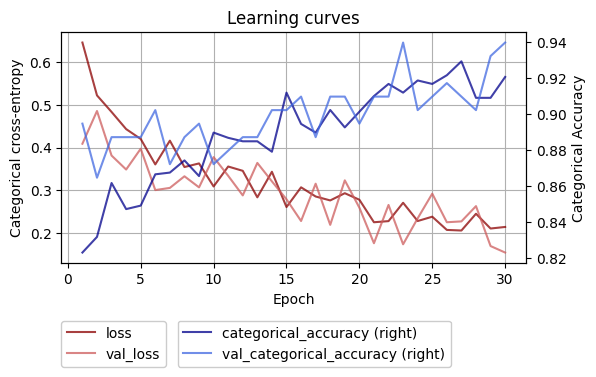

In [ ]:
# Ploting out the learning curves
plot_learning_curves(history)

##2.Using convolutional base of the MobileNetV2

Similarly to what we already have done for VGG16, we are going to implement 3 techniques for MobileNetV2:

*  Fast Feature Extracion
*  Feature Extraction with Data Augmentation 
*  Fine-Tuning

So, we will not duplicate detailed textual description in this section.

###2.1.Fast Feature Extraction without Data Augmentation

In [ ]:
# Importing the MobileNetV2 model from the ``keras.applications`` module
mobilenet_base = keras.applications.mobilenet_v2.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3))

In [ ]:
mobilenet_base.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [ ]:
# Extracting the MobileNetV2 features and corresponding labels
def get_features_and_labels(dataset): 
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.mobilenet_v2.preprocess_input(images)  # notice the 'mobilenet_v2' here
    features = mobilenet_base.predict(preprocessed_images)   # we also use mobile_net base
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)


train_features_mob, train_labels_mob = get_features_and_labels(ds_train) 
val_features_mob, val_labels_mob = get_features_and_labels(ds_validation) 
test_features_mob, test_labels_mob = get_features_and_labels(ds_test)

2/2 [==============================] - 0s 10ms/step


In [ ]:
train_features.shape

(1034, 4, 4, 512)

In [ ]:
# Defining and training the densely connected classifier
inputs = keras.Input(shape=(4, 4, 1280))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units=3, activation="softmax")(x)
model = keras.Model(inputs, outputs)


model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",  
              metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
              metrics.AUC(name='AUROC')])


callbacks = [keras.callbacks.ModelCheckpoint(
             filepath="feature_extraction(mobile).keras",
             save_best_only=True,
             monitor="val_loss")
]

history = model.fit(train_features_mob, train_labels_mob,
                    epochs=20,
                    validation_data=(val_features_mob, val_labels_mob),
                    callbacks=callbacks)

Epoch 1/20
33/33 [==============================] - 1s 14ms/step - loss: 23.1966 - categorical_accuracy: 0.6915 - AUROC: 0.7823 - val_loss: 32.0073 - val_categorical_accuracy: 0.5865 - val_AUROC: 0.6991
Epoch 2/20
33/33 [==============================] - 0s 9ms/step - loss: 5.7536 - categorical_accuracy: 0.8520 - AUROC: 0.8986 - val_loss: 4.2289 - val_categorical_accuracy: 0.8647 - val_AUROC: 0.8965
Epoch 3/20
33/33 [==============================] - 0s 9ms/step - loss: 3.7317 - categorical_accuracy: 0.8839 - AUROC: 0.9242 - val_loss: 3.6205 - val_categorical_accuracy: 0.8872 - val_AUROC: 0.9241
Epoch 4/20
33/33 [==============================] - 0s 9ms/step - loss: 3.2556 - categorical_accuracy: 0.9072 - AUROC: 0.9387 - val_loss: 2.1778 - val_categorical_accuracy: 0.9323 - val_AUROC: 0.9544
Epoch 5/20
33/33 [==============================] - 0s 7ms/step - loss: 3.3918 - categorical_accuracy: 0.9197 - AUROC: 0.9449 - val_loss: 2.6342 - val_categorical_accuracy: 0.9323 - val_AUROC: 0.94

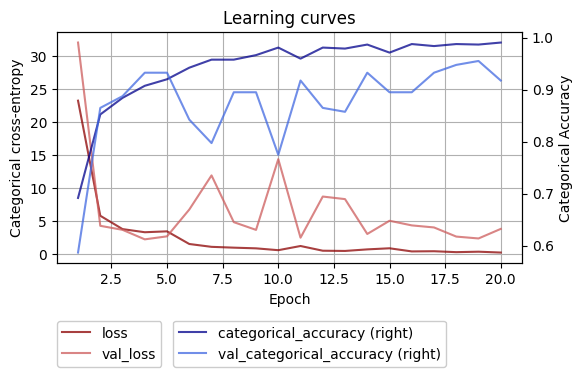

In [ ]:
# Ploting out the learning curves
plot_learning_curves(history)

###2.2.Feature Extraction with Data Augmentation 

Now let’s use MobileNetV2 with augmentation during training. We will not re-define the Augmentation Layer, but rather use the same augmentation that was defined in 1.2.


In [ ]:
# Instantiating and freezing the VGG16 convolutional base
mobilenet_base = keras.applications.mobilenet_v2.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
    )

mobilenet_base.trainable = False

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x) # notice mobilenet 'preprocess_unit' here
x = mobilenet_base(x)  # notice 'mobilenet_base' here
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model= keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",  
              metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
              metrics.AUC(name='AUROC')])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
              filepath="feature_extraction_with_data_augmentation(mobile).keras",
              save_best_only=True,
              monitor="val_loss")]

history = model.fit(ds_train,
                    epochs=50,
                    validation_data=ds_validation,
                    callbacks=callbacks)

Epoch 1/50
17/17 [==============================] - 8s 167ms/step - loss: 49.1070 - categorical_accuracy: 0.5735 - AUROC: 0.6905 - val_loss: 32.8228 - val_categorical_accuracy: 0.6090 - val_AUROC: 0.7260
Epoch 2/50
17/17 [==============================] - 4s 197ms/step - loss: 20.9062 - categorical_accuracy: 0.6838 - AUROC: 0.7671 - val_loss: 18.3859 - val_categorical_accuracy: 0.6917 - val_AUROC: 0.7678
Epoch 3/50
17/17 [==============================] - 3s 99ms/step - loss: 12.6359 - categorical_accuracy: 0.7389 - AUROC: 0.8140 - val_loss: 31.1174 - val_categorical_accuracy: 0.4812 - val_AUROC: 0.6012
Epoch 4/50
17/17 [==============================] - 3s 120ms/step - loss: 14.6624 - categorical_accuracy: 0.7147 - AUROC: 0.7954 - val_loss: 3.2195 - val_categorical_accuracy: 0.8722 - val_AUROC: 0.9159
Epoch 5/50
17/17 [==============================] - 3s 99ms/step - loss: 12.3758 - categorical_accuracy: 0.7437 - AUROC: 0.8197 - val_loss: 4.3930 - val_categorical_accuracy: 0.8571 - va

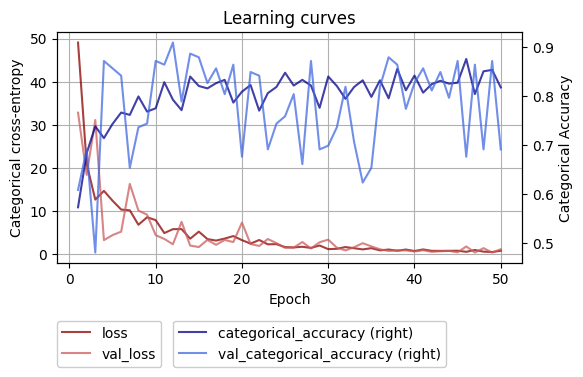

In [ ]:
# Ploting out the learning curves
plot_learning_curves(history)

###2.3. Fine-tuning the pretrained model

In [ ]:
# Printing out the 'mobilenet_base' structure
mobilenet_base.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_7[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [ ]:
# We will fine-tune the last layers, starting from block_16 and later.
# So, unfreezing all the layers until the 11th from the last
mobilenet_base.trainable = True

for layer in mobilenet_base.layers[:-11]:
    layer.trainable = False

In [ ]:
# Fine-tuning the model
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), 
              metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
              metrics.AUC(name='AUROC')])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning(mobile).keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_validation,
    callbacks=callbacks)

Epoch 1/30
17/17 [==============================] - 10s 175ms/step - loss: 0.5645 - categorical_accuracy: 0.8162 - AUROC: 0.9425 - val_loss: 0.7839 - val_categorical_accuracy: 0.7293 - val_AUROC: 0.9248
Epoch 2/30
17/17 [==============================] - 3s 127ms/step - loss: 0.4412 - categorical_accuracy: 0.8559 - AUROC: 0.9581 - val_loss: 0.6588 - val_categorical_accuracy: 0.7744 - val_AUROC: 0.9362
Epoch 3/30
17/17 [==============================] - 4s 161ms/step - loss: 0.4531 - categorical_accuracy: 0.8472 - AUROC: 0.9555 - val_loss: 0.6019 - val_categorical_accuracy: 0.7895 - val_AUROC: 0.9422
Epoch 4/30
17/17 [==============================] - 3s 126ms/step - loss: 0.4092 - categorical_accuracy: 0.8617 - AUROC: 0.9608 - val_loss: 0.5492 - val_categorical_accuracy: 0.7895 - val_AUROC: 0.9458
Epoch 5/30
17/17 [==============================] - 3s 104ms/step - loss: 0.3478 - categorical_accuracy: 0.8656 - AUROC: 0.9698 - val_loss: 0.5645 - val_categorical_accuracy: 0.7895 - val_AUR

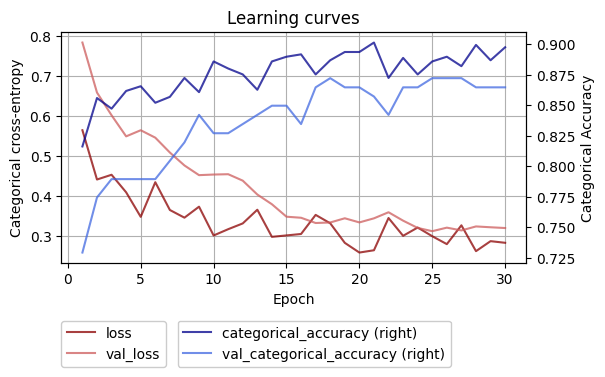

In [ ]:
# Ploting out the learning curves
plot_learning_curves(history)

##3. Comparing Results on Test Dataset

In [ ]:
# Evaluating the built models on the test set

###############
##### VGG #####
###############
# 1.1
test_model = keras.models.load_model("feature_extraction.keras")
result = test_model.evaluate(test_features, test_labels)
print("feature_extraction.keras") 
print(result)

# 1.2 
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
result = test_model.evaluate(ds_test) 
print("feature_extraction_with_data_augmentation.keras")
print(result)

# 1.3
test_model = keras.models.load_model("fine_tuning.keras")
result = test_model.evaluate(ds_test) 
print("fine_tuning.keras")
print(result)

#######################
##### MobileNetV2 #####
#######################
# 2.1
test_model = keras.models.load_model("feature_extraction(mobile).keras")
result = test_model.evaluate(test_features_mob, test_labels_mob) 
print("feature_extraction(mobile).keras")
print(result)

# 2.2
test_model = keras.models.load_model("feature_extraction_with_data_augmentation(mobile).keras")
result = test_model.evaluate(ds_test)
print("feature_extraction_with_data_augmentation(mobile).keras")
print(result)

# 2.3
test_model = keras.models.load_model("fine_tuning(mobile).keras")
result = test_model.evaluate(ds_test) 
print("fine_tuning(mobile).keras")
print(result)

4/4 [==============================] - 0s 5ms/step - loss: 11.4074 - categorical_accuracy: 0.8438 - AUROC: 0.8933
feature_extraction.keras
[11.407367706298828, 0.84375, 0.893310546875]
2/2 [==============================] - 1s 103ms/step - loss: 0.5830 - categorical_accuracy: 0.8359 - AUROC: 0.9530
feature_extraction_with_data_augmentation.keras
[0.5830498933792114, 0.8359375, 0.952972412109375]
2/2 [==============================] - 1s 118ms/step - loss: 0.3251 - categorical_accuracy: 0.8828 - AUROC: 0.9832
fine_tuning.keras
[0.3250713348388672, 0.8828125, 0.9832305908203125]
4/4 [==============================] - 0s 10ms/step - loss: 5.0234 - categorical_accuracy: 0.8672 - AUROC: 0.9106
feature_extraction(mobile).keras
[5.0233869552612305, 0.8671875, 0.91058349609375]
2/2 [==============================] - 1s 44ms/step - loss: 0.2776 - categorical_accuracy: 0.8672 - AUROC: 0.9798
feature_extraction_with_data_augmentation(mobile).keras
[0.2776188254356384, 0.8671875, 0.979766845703125

## Outcomes

The current notebook contains implementation of Transfer Learning technique applied to the bean plants image dataset. 

In particular, we took an existing convnets available in Keras (the VGG16 network and the MobileNetV2 network previously trained on ImageNet) and re-used them on the dataset of bean plants. (The reasoning for choosing these specific networks is covered in the corresponing section of the current notebook).

For both, VGG16 and MobileNetV2, we implemented Feature Extraction in two ways: 
1. Fast Feature Extraction from base without data augmentation.
2. Feature Extraction with data augmentation layer. 

In addition to Feature Extraction, we also performed Fine Tuning of the pretrained models: after training the classification part, we have unfreezed the latest blocks of the pretrained models to allow their training process too. As a result, some of the representations previously learned by the VGG16 and MobileNetV2 networks were adapted to the classification problem of beans. 

The results obtained on the test (unseen) dataset are summarized in the table below:

|              | categorical_crossentropy (loss) | categorical_accuracy  | AUROC  |
|:----------------|:----------:|:----------:| -----:|
| **VGG16** |  |  | |
| Feature Extraction only | 11.4074 | 0.8438 | 0.8933|
|Feature Extraction with Augmentation | 0.5830 | 0.8359 | 0.9530 | 
|Fine-tuning| 0.3251 | 0.8828 | 0.9832 |
| **MobileNetV2** |  |  | |
| Feature Extraction only | 5.0234 | 0.8672 | 0.9106 |
|Feature Extraction with Augmentation | 0.2776 | 0.8672 | 0.9798  | 
|Fine-tuning| 0.3870 | 0.8438 | 0.9626 |

As can be seen, the best results in terms of categorical accuracy and AUROC have been obtained for the pretrained VGG16 network by fine-tuning its last layers. 

At the same time, if we have a requirement for the model to be deployed on a mobile device and used in the fields by farmers, then using MobileNetV2 would be more preferrable. In this case, we could pick the Feature Extraction with Augmentation based on MobileNetV2.